# Assignment 1 - Security and Privacy of Machine Learning
### By Daan Brugmans (s1080742)

This notebook contains the implementation of Assignment 1 for the Radboud University course Security and Privacy of Machine Learning.
The topic at hand is to execute and analyze evasion attacks on convolutional neural networks.
Specifically, this notebook wil look at targeted and untargeted versions of the Fast Gradient Sign Method (FGSM), Projected Gradient Descent (PGD), and Auto-PGD attacks.

This notebook is divided into two parts.
In the first part, we will set up and define all components that we need in order to answer the questions posed in the assignment.
In the second part, we will answer the questions in a Q&A-style by providing the question, the code that will give us an answer, and the answer itself.

This notebook should show all results without being needed to run.
However, if you do want to run this notebook, I have provided a `requirements.txt` that you can use to install all the required packages.
You can also find this notebook with [this URL](https://github.com/daanbrugmans/ru-security-and-privacy-of-machine-learning-23-24/blob/main/assignment-1/assignment-1.ipynb).

## Part 1: Setup

### 1.1 Imports
We will use PyTorch as the main environment for our deep learning endeavors. To this end, we will use the `torch`, `torchvision`, and `torchattacks` packages.

In [43]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import torch
import torchvision
import torchattacks

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from tqdm import tqdm

### 1.2 Preparation
Some preparatory code is performed here: we set a seed for `torch`, `numpy`, and `random` for reproducibility, and we set the device on which we will perform our model training.

In [2]:
def set_global_seed(seed):
    """Sets the same seed for varying libraries.
    
    Taken from week 5 lab notebook (Evasion Attacks (Defenses), dr. Picek)"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
set_global_seed(3131)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if str(device) == "cuda":
    print(torch.cuda.get_device_name())

cuda
NVIDIA GeForce GTX 1050


### 1.3 Data
We load the CIFAR-10 dataset using `torchvision`. When called, the function below returns 3 `DataLoader` objects: for the train set, the validation set, and the test set respectively.

In [3]:
def get_cifar10_dataloaders(dataset_download_path="d:/Datasets", train_split=0.8) -> tuple[DataLoader, DataLoader, DataLoader]:
    cifar10_dataset_train_val = torchvision.datasets.CIFAR10(root=dataset_download_path, train=True, download=True, transform=torchvision.transforms.ToTensor())
    cifar10_dataset_test = torchvision.datasets.CIFAR10(root=dataset_download_path, train=False, download=True, transform=torchvision.transforms.ToTensor())
    
    train_size = int(len(cifar10_dataset_train_val) * train_split)
    val_size = int(len(cifar10_dataset_train_val) - train_size)
    cifar10_dataset_train, cifar10_dataset_val = random_split(cifar10_dataset_train_val, [train_size, val_size])
    
    cifar10_dataloader_train = DataLoader(cifar10_dataset_train, batch_size=128, shuffle=True)
    cifar10_dataloader_val = DataLoader(cifar10_dataset_val, batch_size=128, shuffle=False)
    cifar10_dataloader_test = DataLoader(cifar10_dataset_test, batch_size=128, shuffle=False)
    
    return cifar10_dataloader_train, cifar10_dataloader_val, cifar10_dataloader_test

### 1.4 Neural Network
The following code block consists of two classes.

The first class is called `CIFAR10NeuralNet`.
It is a PyTorch convolutional network.
It consists of two convolution blocks, followed by three linear blocks, and finally a Softmax block.
This is the architecture of the models that we train on the CIFAR-10 dataset.
My general approach for this architecture is to upsample the number of output channels significantly during convolution, so that the model can learn varying features from the different channels, and then to iteratively decrease the number of neurons in the linear layers, so that the most important and general features from the channels can be extracted.

The second class is called `NeuralModel`.
This class is a collection of all processes and objects that are needed for training a `CIFAR10NeuralNet`.
It contains an instance of the `CIFAR10NeuralNet`, its loss function, and its optimizer.
It also contains functions for training and testing the `CIFAR10NeuralNet`, both using regular clean data, as wel as adversarial training.
Finally, it contains a function that can be used to plot the train/validation loss and accuracy for the most recent training run.

I have chosen to implement it this way, so that all code related to the neural network and its architecture is encapsulated within a single class.
In my opinion, this makes performing varying attacks very clean: with only a few rows of code, I am able to instantiate and train a new model.
This makes the experiments easy to read and hides away set implementation details.

In [91]:
class CIFAR10NeuralNet(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.convolutional_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=30, kernel_size=2, stride=1, padding=0, dilation=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.convolutional_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=90, kernel_size=2, stride=1, padding=0, dilation=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.linear_block_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=90*7*7, out_features=2048),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.linear_block_2 = nn.Sequential(
            nn.Linear(in_features=2048, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.linear_block_3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )
        
        self.softmax_block = nn.Sequential(
            nn.Linear(in_features=128, out_features=10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.convolutional_block_1(x)
        x = self.convolutional_block_2(x)
        x = self.linear_block_1(x)
        x = self.linear_block_2(x)
        x = self.linear_block_3(x)
        x = self.softmax_block(x)
        
        return x
    
class NeuralModel:
    def __init__(self) -> None:
        self.neural_network = CIFAR10NeuralNet().to(device)
        self.loss_function = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.neural_network.parameters(), lr=0.001)
        
        self.train_data, self.val_data, self.test_data = get_cifar10_dataloaders()
        
        self.history = None
        
    def train_clean(self, epochs=10):
        """Train the network with clean examples."""
        
        # Keep record of loss and accuracy metrics for most recent training procedure
        self.history = {
            "Train Type": "Clean",
            "Train Loss": [],
            "Validation Loss": [],
            "Train Accuracy": [],
            "Validation Accuracy": []
        }
        
        for epoch in range(epochs):
            print(f"Started Epoch {epoch + 1}")
            
            self.neural_network.train()
            
            # Train
            print(" Training...")
            
            train_batch_losses = []
            train_batch_accuracies = []
            
            for images, targets in tqdm(self.train_data):
                images = images.to(device)
                targets = targets.to(device)
                
                predictions = self.neural_network(images)
                
                # Calculate train loss and backpropagate
                train_batch_loss = self.loss_function(predictions, targets)
                train_batch_losses.append(train_batch_loss)
                train_batch_loss.backward()
                
                # Move predictions and labels to cpu for accuracy calculation
                predictions = torch.max(predictions, dim=1)[1]
                predictions = predictions.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                
                # Calculate train accuracy
                train_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                train_batch_accuracies.append(train_batch_accuracy)
                
                # Step optimizer and clean gradients
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            # Calculate epoch loss and accuracy    
            train_epoch_loss = float(torch.stack(train_batch_losses).mean())
            self.history["Train Loss"].append(train_epoch_loss)
            
            train_epoch_accuracy = np.mean(train_batch_accuracies)
            self.history["Train Accuracy"].append(train_epoch_accuracy)
                
            # Validate
            print(" Validating...")
            
            val_batch_losses = []
            val_batch_accuracies = []
            
            with torch.no_grad():
                self.neural_network.eval()
                
                for images, targets in tqdm(self.val_data):
                    images = images.to(device)
                    targets = targets.to(device)
                    
                    predictions = self.neural_network(images)
                    
                    # Calculate validation loss
                    val_batch_loss = self.loss_function(predictions, targets)
                    val_batch_losses.append(val_batch_loss)
                    
                    # Move predictions and labels to cpu for accuracy calculation
                    predictions = torch.max(predictions, dim=1)[1]
                    predictions = predictions.cpu().detach().numpy()
                    targets = targets.cpu().detach().numpy()
                    
                    # Calculate validation loss
                    val_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                    val_batch_accuracies.append(val_batch_accuracy)
            
            # Calculate epoch loss and accuracy        
            val_epoch_loss = float(torch.stack(val_batch_losses).mean())
            self.history["Validation Loss"].append(val_epoch_loss)
            
            val_epoch_accuracy = np.mean(val_batch_accuracies)
            self.history["Validation Accuracy"].append(val_epoch_accuracy)
            
    def train_adversarial(self, attack_model, epochs=10):
        """Train the neural network with adversarial examples."""
        
        # Keep record of loss and accuracy metrics for most recent training procedure
        attack_name = str(type(attack_model)).split(".")[-1][:-1]
        self.history = {
            "Train Type": f"Adversarial ({attack_name})",
            "Train Loss": [],
            "Validation Loss": [],
            "Train Accuracy": [],
            "Validation Accuracy": []
        }
        
        for epoch in range(epochs):
            print(f"Started Epoch {epoch + 1}")
            
            self.neural_network.train()
            
            # Train
            print(" Training...")
            
            train_batch_losses = []
            train_batch_accuracies = []
            
            for images, targets in tqdm(self.train_data):
                images = images.to(device)
                targets = targets.to(device)
                
                # Generate adversarial samples from training data                
                adversarial_images = attack_model(images, targets)
                adversarial_images = adversarial_images.to(device)
                
                predictions = self.neural_network(adversarial_images)
                
                # Calculate train loss and backpropagate
                train_batch_loss = self.loss_function(predictions, targets)
                train_batch_losses.append(train_batch_loss)
                train_batch_loss.backward()
                
                # Move predictions and labels to cpu for accuracy calculation
                predictions = torch.max(predictions, dim=1)[1]
                predictions = predictions.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                
                # Calculate train accuracy
                train_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                train_batch_accuracies.append(train_batch_accuracy)
                
                # Step optimizer and clean gradients
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            # Calculate epoch loss and accuracy    
            train_epoch_loss = float(torch.stack(train_batch_losses).mean())
            self.history["Train Loss"].append(train_epoch_loss)
            
            train_epoch_accuracy = np.mean(train_batch_accuracies)
            self.history["Train Accuracy"].append(train_epoch_accuracy)
                
            # Validate
            print(" Validating...")
            
            val_batch_losses = []
            val_batch_accuracies = []
            
            self.neural_network.eval()
            
            for images, targets in tqdm(self.val_data):
                images = images.to(device)
                targets = targets.to(device).detach()
                
                # Generate adversarial samples from validation data
                adversarial_images = attack_model(images, targets)
                adversarial_images = adversarial_images.to(device)
                
                predictions = self.neural_network(images).detach()
                
                # Calculate validation loss
                val_batch_loss = self.loss_function(predictions, targets)
                val_batch_losses.append(val_batch_loss)
                
                # Move predictions and labels to cpu for accuracy calculation
                predictions = torch.max(predictions, dim=1)[1]
                predictions = predictions.cpu().numpy()
                targets = targets.cpu().numpy()
                
                # Calculate validation loss
                val_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                val_batch_accuracies.append(val_batch_accuracy)
            
            # Calculate epoch loss and accuracy        
            val_epoch_loss = float(torch.stack(val_batch_losses).mean())
            self.history["Validation Loss"].append(val_epoch_loss)
            
            val_epoch_accuracy = np.mean(val_batch_accuracies)
            self.history["Validation Accuracy"].append(val_epoch_accuracy)
            
    def test_clean(self):
        """Test the model on clean data. Returns the clean test loss and clean test accuracy."""
        
        with torch.no_grad():
            print(" Testing...")
            
            test_batch_losses = []
            test_batch_accuracies = []
            
            self.neural_network.eval()
            
            for images, targets in tqdm(self.test_data):
                images = images.to(device)
                targets = targets.to(device)
                
                predictions = self.neural_network(images)
                
                # Calculate validation loss
                test_batch_loss = self.loss_function(predictions, targets)
                test_batch_losses.append(test_batch_loss)
                
                # Move predictions and labels to cpu for accuracy calculation
                predictions = torch.max(predictions, dim=1)[1]
                predictions = predictions.cpu().detach().numpy()
                targets = targets.cpu().detach().numpy()
                
                # Calculate validation loss
                test_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
                test_batch_accuracies.append(test_batch_accuracy)
                
            # Calculate test loss and accuracy     
            test_loss = float(torch.stack(test_batch_losses).mean())
            test_accuracy = np.mean(test_batch_accuracies)
        
            return test_loss, test_accuracy
    
    def test_adversarial(self, attack_model, attack_target=None):
        """Test the model on adversarial data. Returns the adversarial test loss and the adversarial test accuracy."""
        
        print(" Testing...")
        
        test_batch_losses = []
        test_batch_accuracies = []
        
        self.neural_network.eval()
        
        for images, targets in tqdm(self.val_data):
            images = images.to(device)
            targets = targets.to(device).detach()
            
            # Generate adversarial samples from validation data
            if attack_target is not None:
                targets = torch.full_like(targets, attack_target)
            
            adversarial_images = attack_model(images, targets)
            adversarial_images = adversarial_images.to(device)
            
            predictions = self.neural_network(images).detach()
            
            # Calculate validation loss
            test_batch_loss = self.loss_function(predictions, targets)
            test_batch_losses.append(test_batch_loss)
            
            # Move predictions and labels to cpu for accuracy calculation
            predictions = torch.max(predictions, dim=1)[1]
            predictions = predictions.cpu().numpy()
            targets = targets.cpu().numpy()
            
            # Calculate validation loss
            test_batch_accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=targets)
            test_batch_accuracies.append(test_batch_accuracy)
            
        # Calculate test loss and accuracy     
        test_loss = float(torch.stack(test_batch_losses).mean())
        test_accuracy = np.mean(test_batch_accuracies)
    
        return test_loss, test_accuracy
    
    def plot_history(self):
        """Plot the train and validation losses and accuracies for the latest training round."""
        
        if self.history == None:
            raise ValueError("Training history could not be found. Please train the model prior to plotting its losses.")
        
        _, axes = plt.subplots(2, 1, figsize=(15, 8))
        
        axes[0].plot(range(len(self.history["Train Loss"])), self.history["Train Loss"], label="Train")
        axes[0].plot(range(len(self.history["Validation Loss"])), self.history["Validation Loss"], label="Validation")
        axes[0].set_title(f"Train and Validation Losses for {self.history['Train Type']} Data")
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("Loss")
        axes[0].legend()
        
        axes[1].plot(range(len(self.history["Train Accuracy"])), self.history["Train Accuracy"], label="Train")
        axes[1].plot(range(len(self.history["Validation Accuracy"])), self.history["Validation Accuracy"], label="Validation")
        axes[1].set_title(f"Train and Validation Accuracies for {self.history['Train Type']} Data")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()


### 1.5 Attacks
Here, we define the attacks that we will perform on our neural network.
We define three attack models: the Fast Gradient Sign Method (FGSM), the Gradient Descent Projection (GPD), and the Auto-GPD (AGPD) attacks.
The implementations of these models are directly taken from the `torchattacks` library.
They are included here, because we want to make slight alterations to the standard implementation of `torchattacks`, so that all attacks can be performed both targeted as well as untargeted.
The class descriptions for every attack model contains a direct URL that will guide you towards the original implementation.

In [92]:
class FGSM(torchattacks.attack.Attack):
    """FGSM attack. Taken from torchattacks: https://adversarial-attacks-pytorch.readthedocs.io/en/latest/_modules/torchattacks/attacks/fgsm.html#FGSM"""

    def __init__(self, model, eps=8/255):
        super().__init__("FGSM", model)
        self.eps = eps
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        """
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Calculate loss
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(
            cost, images, retain_graph=False, create_graph=False
        )[0]

        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images
    
class PGD(torchattacks.attack.Attack):
    """PGD attack. Taken from torchvision: https://adversarial-attacks-pytorch.readthedocs.io/en/latest/_modules/torchattacks/attacks/pgd.html#PGD"""

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        """
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images
    
class AutoPGD(torchattacks.attack.Attack):
    """Auto-PGD attack. Taken from torchattacks: https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html#module-torchattacks.attacks.apgd
    
    The function has been altered so that targeted attacks are made possible."""

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        steps=10,
        n_restarts=1,
        seed=0,
        loss="ce",
        eot_iter=1,
        rho=0.75,
        verbose=False,
    ):
        super().__init__("APGD", model)
        self.eps = eps
        self.steps = steps
        self.norm = norm
        self.n_restarts = n_restarts
        self.seed = seed
        self.loss = loss
        self.eot_iter = eot_iter
        self.thr_decr = rho
        self.verbose = verbose
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        
        # Newly introduced check for targeted attack
        if self.targeted:
            target_labels = self.get_target_label(images, labels)
            _, adv_images = self.perturb(images, target_labels, cheap=True)
        else:
            _, adv_images = self.perturb(images, labels, cheap=True)

        return adv_images

    def check_oscillation(self, x, j, k, y5, k3=0.75):
        t = np.zeros(x.shape[1])
        for counter5 in range(k):
            t += x[j - counter5] > x[j - counter5 - 1]

        return t <= k * k3 * np.ones(t.shape)

    def check_shape(self, x):
        return x if len(x.shape) > 0 else np.expand_dims(x, 0)

    def dlr_loss(self, x, y):
        x_sorted, ind_sorted = x.sort(dim=1)
        ind = (ind_sorted[:, -1] == y).float()

        return -(
            x[np.arange(x.shape[0]), y]
            - x_sorted[:, -2] * ind
            - x_sorted[:, -1] * (1.0 - ind)
        ) / (x_sorted[:, -1] - x_sorted[:, -3] + 1e-12)

    def attack_single_run(self, x_in, y_in):
        x = x_in.clone() if len(x_in.shape) == 4 else x_in.clone().unsqueeze(0)
        y = y_in.clone() if len(y_in.shape) == 1 else y_in.clone().unsqueeze(0)

        self.steps_2, self.steps_min, self.size_decr = (
            max(int(0.22 * self.steps), 1),
            max(int(0.06 * self.steps), 1),
            max(int(0.03 * self.steps), 1),
        )
        if self.verbose:
            print(
                "parameters: ", self.steps, self.steps_2, self.steps_min, self.size_decr
            )

        if self.norm == "Linf":
            t = 2 * torch.rand(x.shape).to(self.device).detach() - 1
            x_adv = x.detach() + self.eps * torch.ones([x.shape[0], 1, 1, 1]).to(
                self.device
            ).detach() * t / (
                t.reshape([t.shape[0], -1])
                .abs()
                .max(dim=1, keepdim=True)[0]
                .reshape([-1, 1, 1, 1])
            )  # nopep8
        elif self.norm == "L2":
            t = torch.randn(x.shape).to(self.device).detach()
            x_adv = x.detach() + self.eps * torch.ones([x.shape[0], 1, 1, 1]).to(
                self.device
            ).detach() * t / (
                (t ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12
            )  # nopep8
        x_adv = x_adv.clamp(0.0, 1.0)
        x_best = x_adv.clone()
        x_best_adv = x_adv.clone()
        loss_steps = torch.zeros([self.steps, x.shape[0]])
        loss_best_steps = torch.zeros([self.steps + 1, x.shape[0]])
        acc_steps = torch.zeros_like(loss_best_steps)

        if self.loss == "ce":
            criterion_indiv = nn.CrossEntropyLoss(reduction="none")
        elif self.loss == "dlr":
            criterion_indiv = self.dlr_loss
        else:
            raise ValueError("unknown loss")

        x_adv.requires_grad_()
        grad = torch.zeros_like(x)
        for _ in range(self.eot_iter):
            with torch.enable_grad():
                # 1 forward pass (eot_iter = 1)
                logits = self.get_logits(x_adv)
                
                # Newly introduced to allow targeted attacks
                # ORIGINAL VERSION: loss_indiv = criterion_indiv(logits, y)
                if self.targeted:
                    loss_indiv = -criterion_indiv(logits, y)
                else:
                    loss_indiv = criterion_indiv(logits, y)
                
                loss = loss_indiv.sum()

            # 1 backward pass (eot_iter = 1)
            grad += torch.autograd.grad(loss, [x_adv])[0].detach()

        grad /= float(self.eot_iter)
        grad_best = grad.clone()

        acc = logits.detach().max(1)[1] == y
        acc_steps[0] = acc + 0
        loss_best = loss_indiv.detach().clone()

        step_size = (
            self.eps
            * torch.ones([x.shape[0], 1, 1, 1]).to(self.device).detach()
            * torch.Tensor([2.0]).to(self.device).detach().reshape([1, 1, 1, 1])
        )  # nopep8
        x_adv_old = x_adv.clone()
        counter = 0
        k = self.steps_2 + 0
        u = np.arange(x.shape[0])
        counter3 = 0

        loss_best_last_check = loss_best.clone()
        reduced_last_check = np.zeros(loss_best.shape) == np.zeros(loss_best.shape)

        # n_reduced = 0
        for i in range(self.steps):
            # gradient step
            with torch.no_grad():
                x_adv = x_adv.detach()
                grad2 = x_adv - x_adv_old
                x_adv_old = x_adv.clone()

                a = 0.75 if i > 0 else 1.0

                if self.norm == "Linf":
                    x_adv_1 = x_adv + step_size * torch.sign(grad)
                    x_adv_1 = torch.clamp(
                        torch.min(torch.max(x_adv_1, x - self.eps), x + self.eps),
                        0.0,
                        1.0,
                    )
                    x_adv_1 = torch.clamp(
                        torch.min(
                            torch.max(
                                x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a),
                                x - self.eps,
                            ),
                            x + self.eps,
                        ),
                        0.0,
                        1.0,
                    )

                elif self.norm == "L2":
                    x_adv_1 = x_adv + step_size * grad / (
                        (grad ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt() + 1e-12
                    )  # nopep8
                    x_adv_1 = torch.clamp(
                        x
                        + (x_adv_1 - x)
                        / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12
                        )
                        * torch.min(
                            self.eps * torch.ones(x.shape).to(self.device).detach(),
                            ((x_adv_1 - x) ** 2)
                            .sum(dim=(1, 2, 3), keepdim=True)
                            .sqrt(),
                        ),
                        0.0,
                        1.0,
                    )  # nopep8
                    x_adv_1 = x_adv + (x_adv_1 - x_adv) * a + grad2 * (1 - a)
                    x_adv_1 = torch.clamp(
                        x
                        + (x_adv_1 - x)
                        / (
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12
                        )
                        * torch.min(
                            self.eps * torch.ones(x.shape).to(self.device).detach(),
                            ((x_adv_1 - x) ** 2).sum(dim=(1, 2, 3), keepdim=True).sqrt()
                            + 1e-12,
                        ),
                        0.0,
                        1.0,
                    )  # nopep8

                x_adv = x_adv_1 + 0.0

            # get gradient
            x_adv.requires_grad_()
            grad = torch.zeros_like(x)
            for _ in range(self.eot_iter):
                with torch.enable_grad():
                    # 1 forward pass (eot_iter = 1)
                    logits = self.get_logits(x_adv)
                   
                    # Newly introduced to allow targeted attacks
                    # ORIGINAL VERSION: loss_indiv = criterion_indiv(logits, y)
                    if self.targeted:
                        loss_indiv = -criterion_indiv(logits, y)
                    else:
                        loss_indiv = criterion_indiv(logits, y)
                        
                    loss = loss_indiv.sum()

                # 1 backward pass (eot_iter = 1)
                grad += torch.autograd.grad(loss, [x_adv])[0].detach()

            grad /= float(self.eot_iter)

            pred = logits.detach().max(1)[1] == y
            acc = torch.min(acc, pred)
            acc_steps[i + 1] = acc + 0
            x_best_adv[(pred == 0).nonzero().squeeze()] = (
                x_adv[(pred == 0).nonzero().squeeze()] + 0.0
            )  # nopep8
            if self.verbose:
                print("iteration: {} - Best loss: {:.6f}".format(i, loss_best.sum()))

            # check step size
            with torch.no_grad():
                y1 = loss_indiv.detach().clone()
                loss_steps[i] = y1.cpu() + 0
                ind = (y1 > loss_best).nonzero().squeeze()
                x_best[ind] = x_adv[ind].clone()
                grad_best[ind] = grad[ind].clone()
                loss_best[ind] = y1[ind] + 0
                loss_best_steps[i + 1] = loss_best + 0

                counter3 += 1

                if counter3 == k:
                    fl_oscillation = self.check_oscillation(
                        loss_steps.detach().cpu().numpy(),
                        i,
                        k,
                        loss_best.detach().cpu().numpy(),
                        k3=self.thr_decr,
                    )
                    fl_reduce_no_impr = (~reduced_last_check) * (
                        loss_best_last_check.cpu().numpy() >= loss_best.cpu().numpy()
                    )  # nopep8
                    fl_oscillation = ~(~fl_oscillation * ~fl_reduce_no_impr)
                    reduced_last_check = np.copy(fl_oscillation)
                    loss_best_last_check = loss_best.clone()

                    if np.sum(fl_oscillation) > 0:
                        step_size[u[fl_oscillation]] /= 2.0
                        n_reduced = fl_oscillation.astype(float).sum()

                        fl_oscillation = np.where(fl_oscillation)

                        x_adv[fl_oscillation] = x_best[fl_oscillation].clone()
                        grad[fl_oscillation] = grad_best[fl_oscillation].clone()

                    counter3 = 0
                    k = np.maximum(k - self.size_decr, self.steps_min)

        return x_best, acc, loss_best, x_best_adv

    def perturb(self, x_in, y_in, best_loss=False, cheap=True):
        assert self.norm in ["Linf", "L2"]
        x = x_in.clone() if len(x_in.shape) == 4 else x_in.clone().unsqueeze(0)
        y = y_in.clone() if len(y_in.shape) == 1 else y_in.clone().unsqueeze(0)

        adv = x.clone()
        acc = self.get_logits(x).max(1)[1] == y
        # loss = -1e10 * torch.ones_like(acc).float()
        if self.verbose:
            print(
                "-------------------------- running {}-attack with epsilon {:.4f} --------------------------".format(
                    self.norm, self.eps
                )
            )
            print("initial accuracy: {:.2%}".format(acc.float().mean()))
        startt = time.time()

        if not best_loss:
            torch.random.manual_seed(self.seed)
            torch.cuda.random.manual_seed(self.seed)

            if not cheap:
                raise ValueError("not implemented yet")

            else:
                for counter in range(self.n_restarts):
                    ind_to_fool = acc.nonzero().squeeze()
                    if len(ind_to_fool.shape) == 0:
                        ind_to_fool = ind_to_fool.unsqueeze(0)
                    if ind_to_fool.numel() != 0:
                        x_to_fool, y_to_fool = (
                            x[ind_to_fool].clone(),
                            y[ind_to_fool].clone(),
                        )  # nopep8
                        (
                            best_curr,
                            acc_curr,
                            loss_curr,
                            adv_curr,
                        ) = self.attack_single_run(
                            x_to_fool, y_to_fool
                        )  # nopep8
                        ind_curr = (acc_curr == 0).nonzero().squeeze()
                        #
                        acc[ind_to_fool[ind_curr]] = 0
                        adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                        if self.verbose:
                            print(
                                "restart {} - robust accuracy: {:.2%} - cum. time: {:.1f} s".format(
                                    counter, acc.float().mean(), time.time() - startt
                                )
                            )

            return acc, adv

        else:
            adv_best = x.detach().clone()
            loss_best = torch.ones([x.shape[0]]).to(self.device) * (
                -float("inf")
            )  # nopep8
            for counter in range(self.n_restarts):
                best_curr, _, loss_curr, _ = self.attack_single_run(x, y)
                ind_curr = (loss_curr > loss_best).nonzero().squeeze()
                adv_best[ind_curr] = best_curr[ind_curr] + 0.0
                loss_best[ind_curr] = loss_curr[ind_curr] + 0.0

                if self.verbose:
                    print("restart {} - loss: {:.5f}".format(counter, loss_best.sum()))

            return loss_best, adv_best


## Part 2: Q&A

### 2.1 FGSM

#### 2.1.a 
Q: Execute the untargeted and targeted version of the FGSM attack. Use class cat (class index 3) as your target for the targeted version. Evaluate the accuracy of the model and share your conclusions.

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.53it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 25.93it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:17<00:00, 18.22it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.95it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.61it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.64it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.33it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 31.10it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.77it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 29.20it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.37it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.94it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.63it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 31.45it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:16<00:00, 18.69it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.50it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.07it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.39it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.05it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 26.32it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 33.29it/s]


Clean Test Loss: 1.8680076599121094
Clean Test Accuracy: 0.590684335443038
 Testing...


100%|██████████| 79/79 [00:03<00:00, 23.27it/s]


Adversarial Test Loss: 1.8660321235656738
Adversarial Test Accuracy: 0.5907832278481012


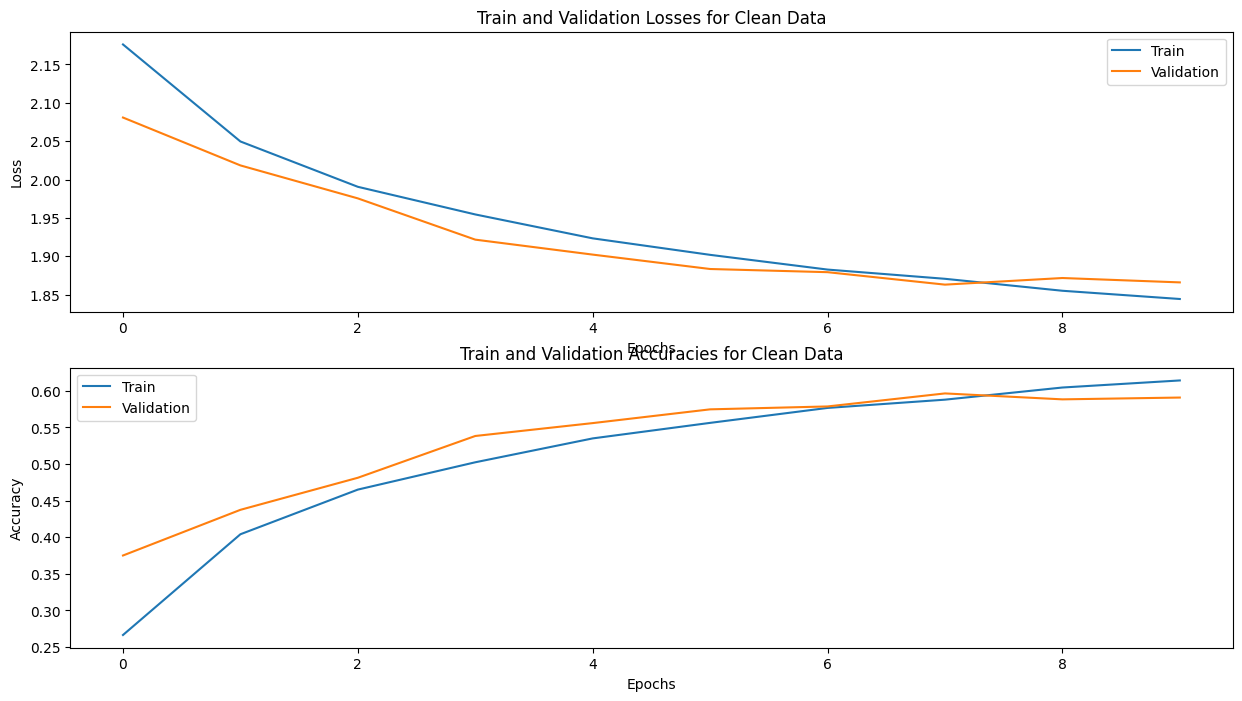

In [93]:
# Clean training with untargeted FGSM attack.

model = NeuralModel()
model.train_clean()
model.plot_history()

untargeted_fgsm = FGSM(model.neural_network, eps=0.2)
untargeted_fgsm.supported_mode = "default"

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(untargeted_fgsm)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:13<00:00, 22.83it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 37.72it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:13<00:00, 23.53it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.17it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.31it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.39it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.65it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.25it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.39it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.26it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.30it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.40it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:15<00:00, 19.99it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 31.17it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.32it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.04it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.04it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.69it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.39it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 28.86it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 28.78it/s]


Clean Test Loss: 1.8581929206848145
Clean Test Accuracy: 0.6027492088607594
 Testing...


100%|██████████| 79/79 [00:03<00:00, 20.13it/s]


Adversarial Test Loss: 2.317030906677246
Adversarial Test Accuracy: 0.1372626582278481


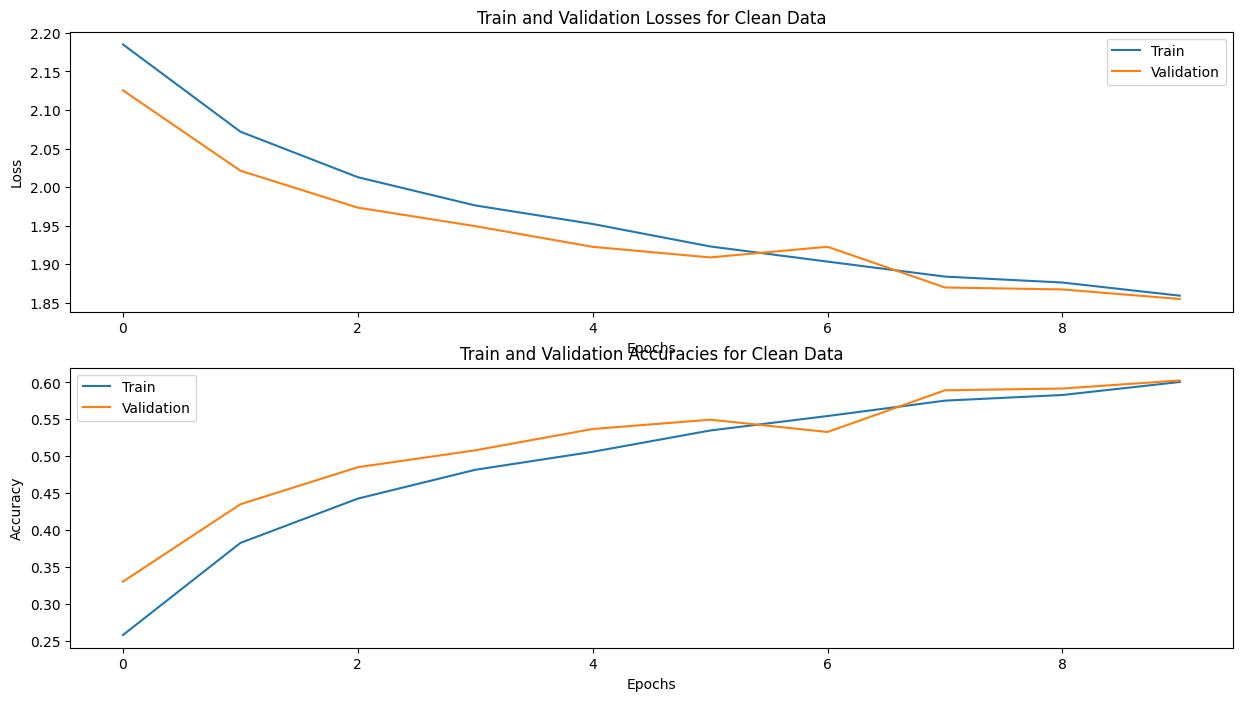

In [94]:
# Clean training with targeted FGSM attack.

model = NeuralModel()
model.train_clean()
model.plot_history()

targeted_fgsm = FGSM(model.neural_network, eps=0.2)
targeted_fgsm.supported_mode = "targeted"

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(targeted_fgsm, attack_target=3)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

A: The clean accuracy of the model is, unfortunately, not great: it is roughly 0.6.
The untargeted adversarial accuracy is also roughly 0.6, while the targeted adversarial accuracy is about 0.14.
We can conclude that the targeted attack is much more damaging to model performance.

#### 2.1.b 
Q: Perform adversarial training using the FGSM attack. Then execute the untargeted and targeted version of the FGSM attack, same settings like in part (a), but now on the adversarial trained model. Evaluate the accuracy of the model and compare results with part (a). Share your conclusions.

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.29it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 21.49it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 22.39it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.35it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.10it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 21.89it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 22.22it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.05it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 22.32it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:18<00:00, 16.79it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 24.52it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:18<00:00, 16.61it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 21.21it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.37it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:18<00:00, 17.06it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.45it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 35.90it/s]


Clean Test Loss: 2.124384880065918
Clean Test Accuracy: 0.3303006329113924
 Testing...


100%|██████████| 79/79 [00:03<00:00, 23.92it/s]


Adversarial Test Loss: 2.1383919715881348
Adversarial Test Accuracy: 0.3113132911392405


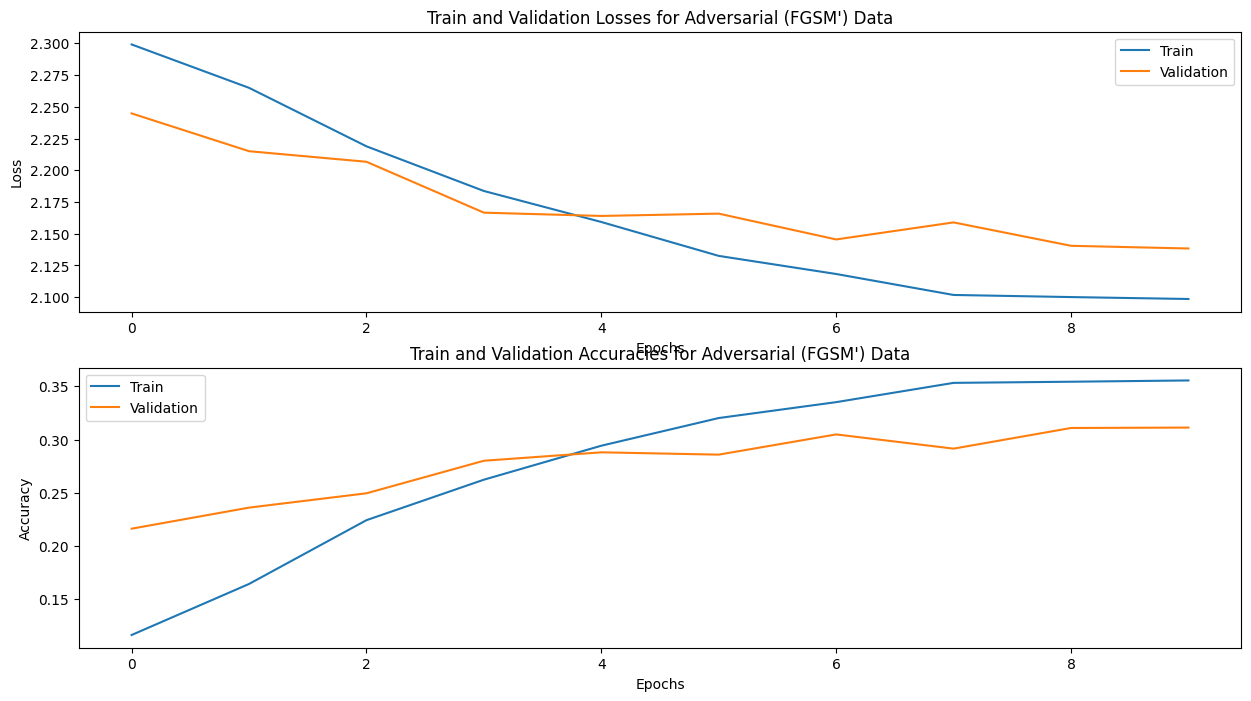

In [95]:
# Adversarial training with untargeted FGSM attack.

model = NeuralModel()

untargeted_fgsm = FGSM(model.neural_network, eps=0.2)
untargeted_fgsm.supported_mode = "default"

model.train_adversarial(untargeted_fgsm)
model.plot_history()

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(untargeted_fgsm)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.30it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.30it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.20it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 22.34it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:19<00:00, 15.68it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 22.55it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.39it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:19<00:00, 15.94it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 24.36it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.38it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.56it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.23it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 22.99it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 20.01it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.19it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 21.02it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:19<00:00, 16.21it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 23.17it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 32.49it/s]


Clean Test Loss: 2.1246144771575928
Clean Test Accuracy: 0.328125
 Testing...


100%|██████████| 79/79 [00:03<00:00, 21.36it/s]


Adversarial Test Loss: 2.209458112716675
Adversarial Test Accuracy: 0.2455498417721519


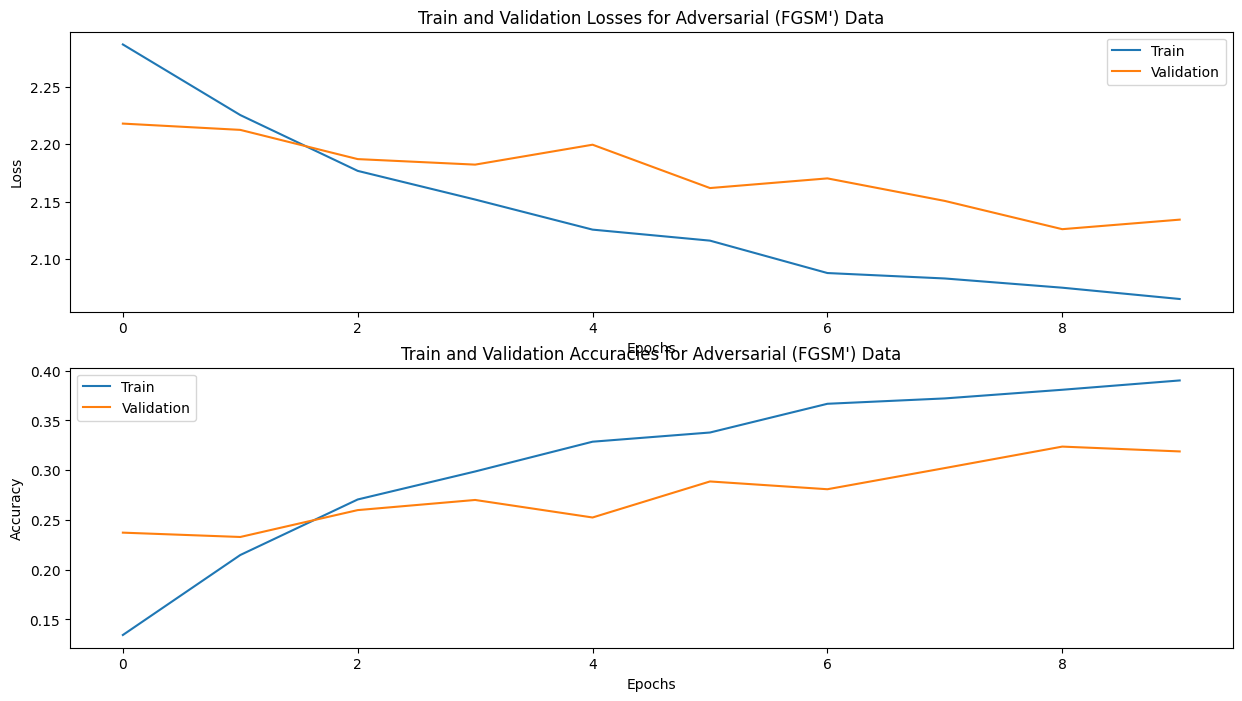

In [96]:
# Adversarial training with targeted FGSM attack.

model = NeuralModel()

targeted_fgsm = FGSM(model.neural_network, eps=0.2)
targeted_fgsm.supported_mode = "targeted"

model.train_adversarial(targeted_fgsm)
model.plot_history()

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(targeted_fgsm, attack_target=3)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

A: When trained adversarially, the model reaches a clean accuracy of roughly 0.33.
This adversarially trained model reaches an adversarial accuracy of roughly 0.30 for untargeted attacks, and roughly 0.25 for targeted attacks.
We can see that, although overall accuracy has dropped notably compared to the model that was trained on clean data, the adversarially trained model is more robust to targeted attacks in particular.
We can conclude that this is a typical example of how adversarial training generally decreases overall accuracy, and that robustness to adversarial examples is a trade-off.

### 2.2 PGD & Auto-PGD

#### 2.2.a
Q: Execute the untargeted version of the PGD and Auto-PGD attacks. Evaluate the results and compare both attacks in terms of success. Share your conclusions.

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.69it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.45it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.58it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 29.54it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.39it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.37it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.72it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.33it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.55it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.13it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:15<00:00, 19.81it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.18it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.43it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 29.86it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.58it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.68it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:15<00:00, 19.67it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.99it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.02it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.50it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 33.53it/s]


Clean Test Loss: 1.8673617839813232
Clean Test Accuracy: 0.5924643987341772
 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.39it/s]


Adversarial Test Loss: 1.8725026845932007
Adversarial Test Accuracy: 0.5857397151898734


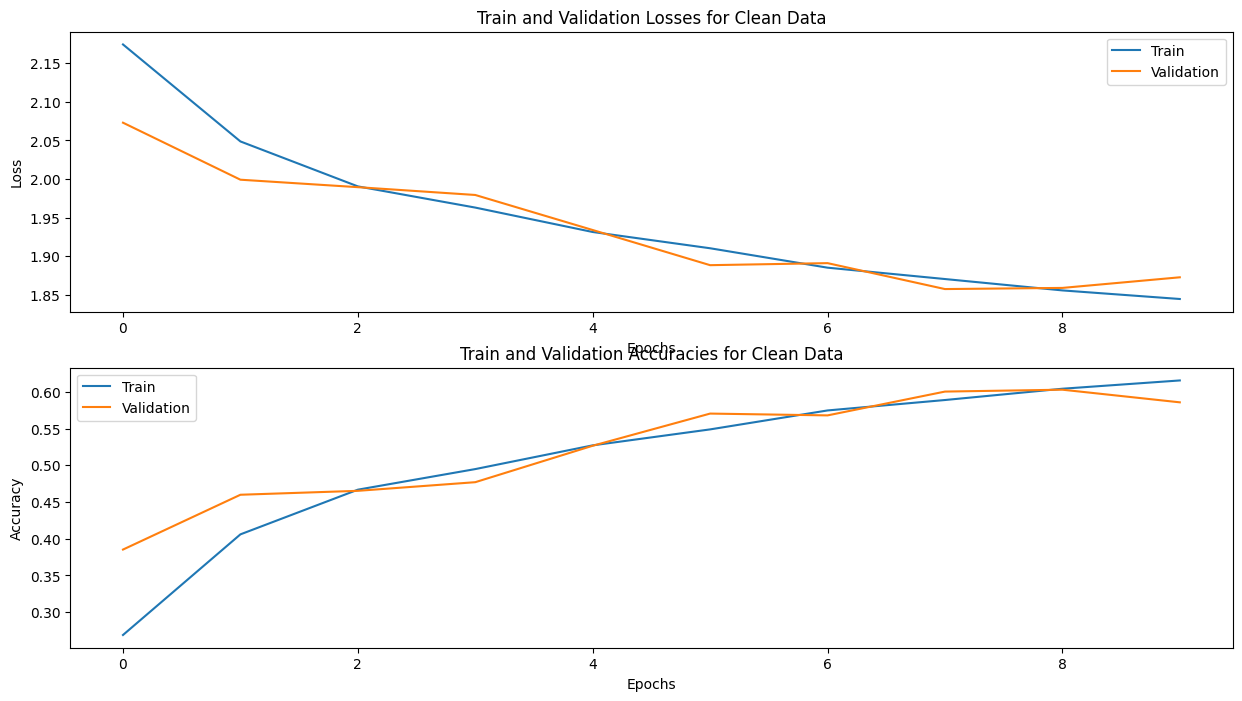

In [97]:
# Clean training with untargeted PGD attack.

model = NeuralModel()
model.train_clean()
model.plot_history()

untargeted_pgd = PGD(model.neural_network, eps=0.2, alpha=2/255, steps=10)
untargeted_pgd.supported_mode = "default"

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(untargeted_pgd)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.20it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 31.84it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.16it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 26.18it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.84it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.97it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.50it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.84it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.73it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 29.92it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.05it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 33.80it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.45it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.56it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.28it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 28.84it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.62it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 29.95it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.04it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 33.32it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 32.88it/s]


Clean Test Loss: 1.843932032585144
Clean Test Accuracy: 0.6159018987341772
 Testing...


100%|██████████| 79/79 [00:17<00:00,  4.60it/s]


Adversarial Test Loss: 1.8397897481918335
Adversarial Test Accuracy: 0.619560917721519


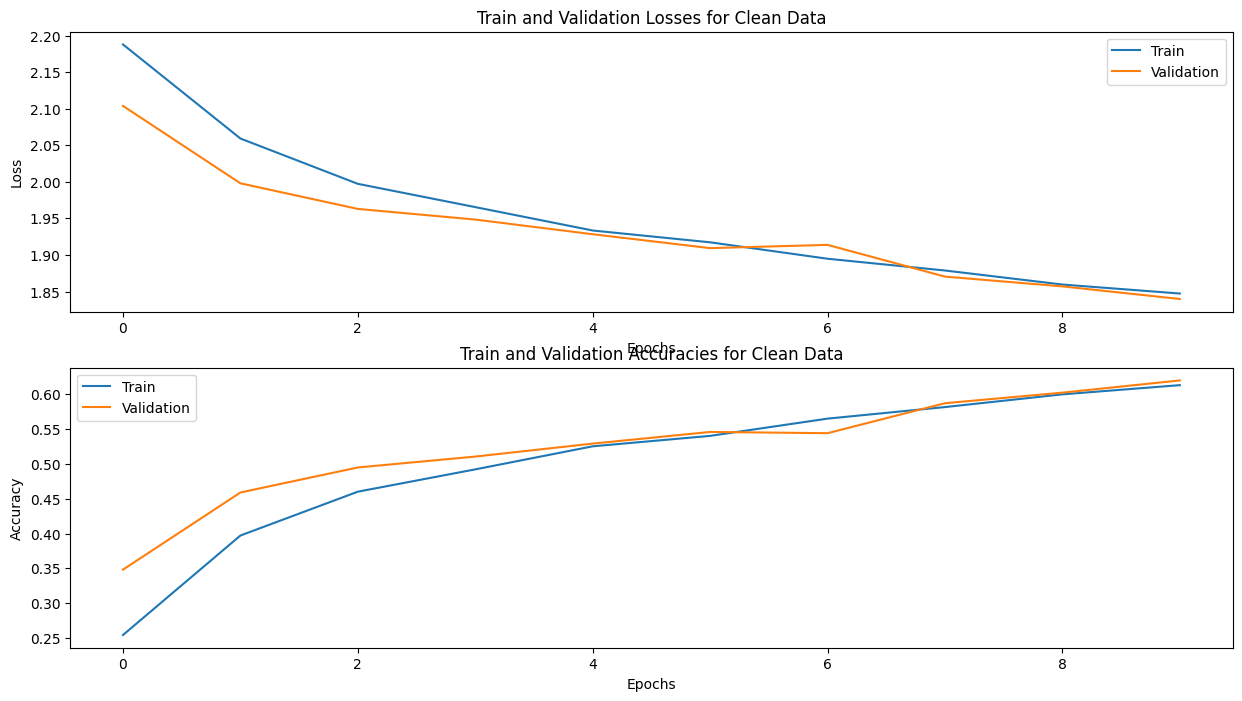

In [98]:
# Clean training with untargeted Auto-PGD attack.

model = NeuralModel()
model.train_clean()
model.plot_history()

untargeted_autopgd = AutoPGD(model.neural_network, norm="Linf", eps=0.2, steps=10, rho=0.75)
untargeted_autopgd.supported_mode = "default"

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(untargeted_autopgd)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

A: The PGD and APGD attacks seem to be unsuccessful.
The clean accuracies achieved by the two model instances are 0.59 and 0.62 respectively.
However, these are also the adversarial accuracies for the PGD and APGD attacks respectively.
This is unexpected.
I conclude that the most likely reason for this result, is that the attacks cannot "fool" the model, because the model is too "stupid" to be properly fooled; it has not learnt the data really well, and is possibly oblivious to the perturbations made in the adversarial examples.
For a future experiment, I would like to try out a different model architecture with more training, and to increase the epsilon value as to make the attacks more potent.

#### 2.2.b
Q: Execute the targeted version of the PGD and Auto-PGD attacks.
Evaluate the results and compare both attacks in terms of success. Use class
cat (class index 3) as your target. Share your conclusions.

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:15<00:00, 19.79it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 38.92it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:13<00:00, 22.65it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 33.17it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.31it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 25.52it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:16<00:00, 18.49it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 26.26it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.55it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.60it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.09it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 26.00it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.01it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.71it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:13<00:00, 22.46it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 25.74it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.24it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:15<00:00, 20.20it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.43it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 35.84it/s]


Clean Test Loss: 1.875093698501587
Clean Test Accuracy: 0.581190664556962
 Testing...


100%|██████████| 79/79 [00:12<00:00,  6.57it/s]


Adversarial Test Loss: 2.360814332962036
Adversarial Test Accuracy: 0.09513449367088607


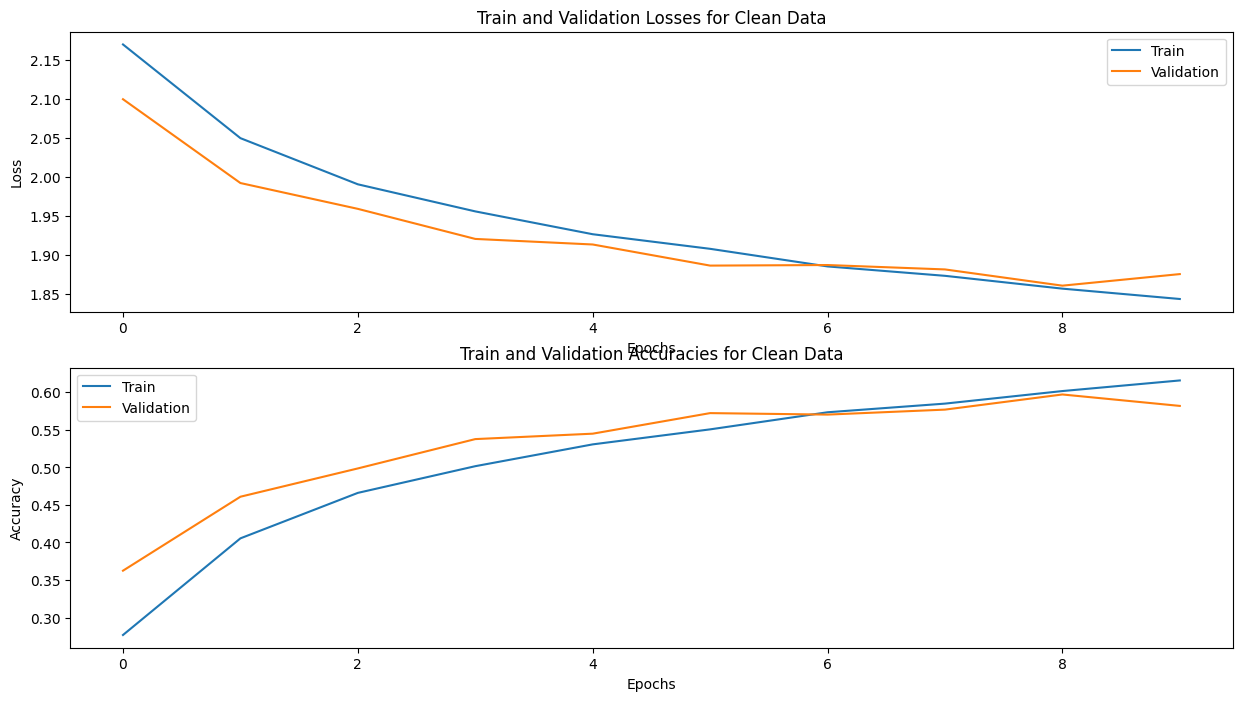

In [99]:
# Clean training with targeted PGD attack.

model = NeuralModel()
model.train_clean()
model.plot_history()

targeted_pgd = PGD(model.neural_network, eps=0.2, alpha=2/255, steps=10)
targeted_pgd.supported_mode = "targeted"

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(targeted_pgd, attack_target=3)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:13<00:00, 24.07it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 36.37it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:12<00:00, 24.38it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 38.55it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:13<00:00, 23.04it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 37.65it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:14<00:00, 20.90it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 28.81it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:14<00:00, 22.16it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.02it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:14<00:00, 22.33it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 35.68it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.87it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 37.60it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:13<00:00, 22.98it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 35.81it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:13<00:00, 22.56it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.18it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.84it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.03it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 30.48it/s]


Clean Test Loss: 1.8318551778793335
Clean Test Accuracy: 0.6287579113924051
 Testing...


100%|██████████| 79/79 [00:10<00:00,  7.78it/s]


Adversarial Test Loss: 2.364546537399292
Adversarial Test Accuracy: 0.09068433544303797


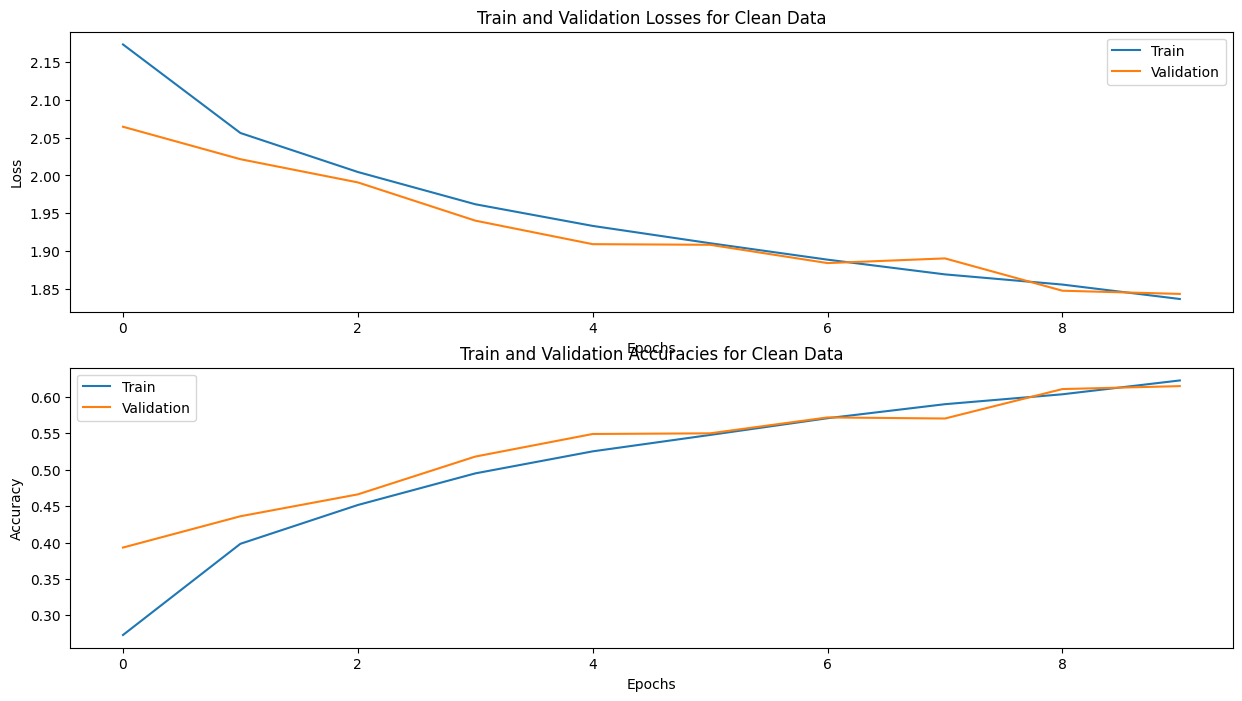

In [102]:
# Clean training with targeted Auto-PGD attack.

model = NeuralModel()
model.train_clean()
model.plot_history()

targeted_autopgd = AutoPGD(model.neural_network, norm="Linf", eps=0.2, steps=10, rho=0.75)
targeted_autopgd.supported_mode = "targeted"

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(targeted_autopgd, attack_target=3)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

A: Both the PGD and APGD attacks seem successful.
The cleanly trained model instances achieve clean accuracies of 0.58 and 0.62 respectively, very similar to the models trained for the untargeted GPD and APGD attacks.
However, being targeted, the PGD attack results in an adversarial accuracy of 0.10, while the APGD attack results in an adversarial accuracy of 0.09.
We can conclude that the model has been successfully attacked.

#### 2.2.c
Q: Explain why the PGD attack starts at a random point (rather than
at the input point itself). Implement and execute the untargeted PGD attack
that starts at the input point. Compare the results with those of the untargeted
PGD attack from part (a).

Files already downloaded and verified
Files already downloaded and verified
Started Epoch 1
 Training...


100%|██████████| 313/313 [00:14<00:00, 20.94it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.52it/s]


Started Epoch 2
 Training...


100%|██████████| 313/313 [00:14<00:00, 22.17it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 33.10it/s]


Started Epoch 3
 Training...


100%|██████████| 313/313 [00:14<00:00, 22.03it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.33it/s]


Started Epoch 4
 Training...


100%|██████████| 313/313 [00:14<00:00, 22.19it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 34.41it/s]


Started Epoch 5
 Training...


100%|██████████| 313/313 [00:16<00:00, 19.53it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 27.21it/s]


Started Epoch 6
 Training...


100%|██████████| 313/313 [00:14<00:00, 21.96it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 30.33it/s]


Started Epoch 7
 Training...


100%|██████████| 313/313 [00:12<00:00, 24.13it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 39.39it/s]


Started Epoch 8
 Training...


100%|██████████| 313/313 [00:13<00:00, 22.52it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 31.75it/s]


Started Epoch 9
 Training...


100%|██████████| 313/313 [00:13<00:00, 23.38it/s]


 Validating...


100%|██████████| 79/79 [00:02<00:00, 32.10it/s]


Started Epoch 10
 Training...


100%|██████████| 313/313 [00:17<00:00, 17.82it/s]


 Validating...


100%|██████████| 79/79 [00:03<00:00, 25.85it/s]


 Testing...


100%|██████████| 79/79 [00:02<00:00, 32.27it/s]


Clean Test Loss: 1.8775486946105957
Clean Test Accuracy: 0.5809928797468354
 Testing...


100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


Adversarial Test Loss: 1.8819442987442017
Adversarial Test Accuracy: 0.5751582278481012


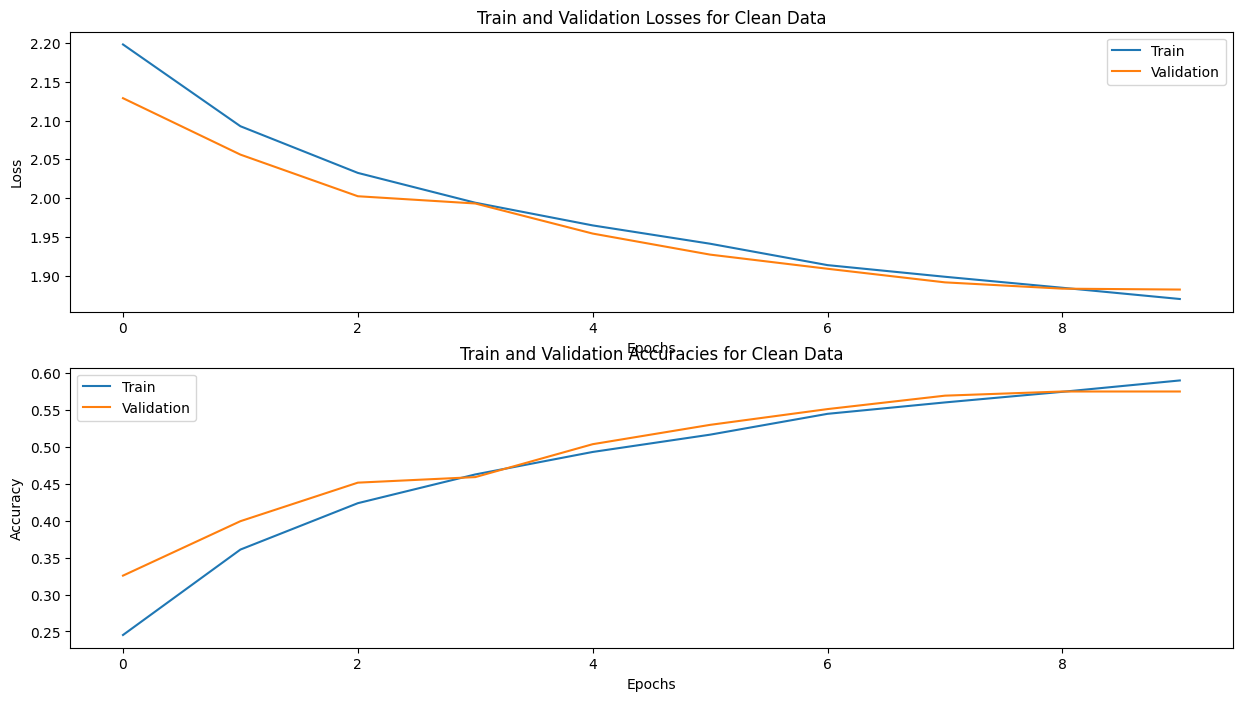

In [101]:
# Clean training with untargeted PGD attack, starting at the input point (as opposed to a random point).

model = NeuralModel()
model.train_clean()
model.plot_history()

untargeted_pgd = PGD(model.neural_network, eps=0.2, alpha=2/255, steps=10)
untargeted_pgd.supported_mode = "default"
untargeted_pgd.random_start = False

test_loss, test_accuracy = model.test_clean()
print("Clean Test Loss:", test_loss)
print("Clean Test Accuracy:", test_accuracy)

test_loss, test_accuracy = model.test_adversarial(untargeted_pgd)
print("Adversarial Test Loss:", test_loss)
print("Adversarial Test Accuracy:", test_accuracy)

A: PGD starts at a random point as opposed to the original input point, because, when attacking a model, we want to find potential perturbations that cause the model to predict a different target than what is correct.
By selecting a random point, we already start out with a perturbation to use, and can search for better perturbations from there.
If we started at the original input, we would first have to search for a perturbation that is far enough from the input for the model to predict a different target, before we could try to optimize our perturbations.

Our implementation of the untargeted PGD starting at the input point does not seem to have led to a successful attack.
The clean accuracy achieved by the model is 0.59, while the adversarial accuracy is 0.57.
This is quite similar to the untargeted PGD attack performed earlier.
I conclude that the reason for this seemingly unsuccessful attack is the same as mentioned earlier: that is, the model is not trained well enough to properly be fooled by the attack.
However, it may be possible that for this attack, the attack model itself did not train well, since it had to start at the original input point.
It might not have been able to find a good perturbation to attack with.

#### 2.2.d
Q: Explain the difference between the PGD and Auto-PGD attacks. Which
shortcomings of PGD have been improved by Auto-PGD?

A: The shortcomings of PGD are discussed by [Corce and Hein](https://arxiv.org/pdf/2003.01690.pdf), authors of the Auto-PGD attack. 
They argue that PGD has three main shortcomings.
First, PGD has a fixed step size, that is very sensitive to change, and cannot guarantee convergence during training.
Second, PGD tends to plateau after only a few iterations of training.
Third, PGD does not take into consideration how and if the training is developing successfully.
Auto-PGD aims to fix these issues by dividing the number of iteration into an exploration phase, where it searches for a good starting point, and an exploitation phase, where it tries to produce the best results.
The transition between these phases is done applying an iteratively reducing step size, whose change is dependent on the current optimization trend.
This means that Auto-PGD improves over PGD by having less hyperparameters (learning those instead) and can adjust the optimization better during training.